In [1]:
def get_sql_text(b, vuelo, zona):
    if vuelo.startswith('vuelo'):
        return f'''
        WITH patches as (
            select id, pa from {vuelo}_zona{zona}
            where pc_intersects(pa, ST_setSRID(\'{b}\'::geometry, 25830))
        ), points_intersection as
        (
            select pc_explode(pc_intersection(pa, ST_setSRID('{b}'::geometry, 25830))) as points 
            from patches
        )
        SELECT pc_get(points, 'heightaboveground') 
        FROM points_intersection
        WHERE pc_get(points, 'Classification') > 3;
        '''
    elif vuelo.startswith('lida'):
        return f'''
        WITH patches as (
            select id, pa from {vuelo}_zona{zona}
            where pc_intersects(pa, ST_setSRID(\'{b}\'::geometry, 25830))
        ), points_intersection as
        (
            select pc_explode(pc_intersection(pa, ST_setSRID('{b}'::geometry, 25830))) as points 
            from patches
        )
        SELECT pc_get(points, 'heightaboveground') 
        FROM points_intersection
        WHERE pc_get(points, 'Classification') > 2 and pc_get(points, 'Classification') < 6;
        '''

In [4]:
import psycopg2

conn = psycopg2.connect(database="pointclouds",
                        host="172.17.0.2",
                        user="postgres",
                        password="ventanuco",
                        port="5432")

In [5]:
from shapely import box
import geopandas as gpd
import numpy as np
import pandas as pd
import math
from scipy.stats import kurtosis
from ipywidgets import IntProgress
from IPython.display import display

def get_biomass_gdf(z, vuelo):
    zonas = gpd.read_file('shp/zonas_estudio.shp')
    zona = zonas[zonas.Id == z]

    res = 10
    bounds = [int(x) for x in zona.total_bounds]
    progress_bar = IntProgress(min=1, max=len(range(bounds[0], bounds[2], res)) * len(range(bounds[1], bounds[3], res)))
    display(progress_bar)
    
    gdf = gpd.GeoDataFrame(columns=['hag', 'geometry'], geometry='geometry', crs='EPSG:25830')
    
    for minx in range(bounds[0], bounds[2], res):
        for miny in range(bounds[1], bounds[3], res):
            b = box(minx, miny, minx + res, miny + res)
            try:
                cursor = conn.cursor()
                cursor.execute(get_sql_text(b, vuelo, z))
                a = np.array([float(x[0]) for x in cursor.fetchall()])
                gdf.loc[len(gdf)] = [a, b]
                progress_bar.value += 1
            except Exception as X:
                cursor.execute('ROLLBACK')
                conn.commit()
                print('Ha habido un error: ', X)
    
    gdf['hag'] = gdf.apply(lambda x: x.hag[x.hag > 0.2], axis=1) # filtro para eliminar errores a la altura del suelo
    gdf['hag'] = gdf.apply(lambda x: x.hag[x.hag < 13], axis=1) # Altura máxima observada de los árboles 11 m aprox, aplico el filtro para eliminar outliers
    gdf['length'] = gdf.apply(lambda x: len(x.hag) if len(x.hag) > 0 else None, axis=1)
    gdf['min'] = gdf.apply(lambda x: min(x.hag) if len(x.hag) > 0 else None, axis=1)
    gdf['max'] = gdf.apply(lambda x: max(x.hag) if len(x.hag) > 0 else None, axis=1)
    gdf['p10'] = gdf.apply(lambda x: np.percentile(x.hag, 10) if len(x.hag) > 0 else None, axis=1)
    gdf['p75'] = gdf.apply(lambda x: np.percentile(x.hag, 75) if len(x.hag) > 0 else None, axis=1)
    gdf['mean'] = gdf.apply(lambda x: x.hag.mean() if len(x.hag) > 0 else None, axis=1)
    
    gdf['kurtosis'] = gdf.apply(lambda x: kurtosis(x.hag) if len(x.hag) > 0 else None, axis=1)
    
    gdf['agb'] = gdf.apply(lambda x: None if pd.isnull(x['mean']) else 0.36 * math.pow(x['mean'], 1.16) * math.pow(x['p75'], 0.78) * math.pow(x['p10'], -0.18) * math.pow(abs(x['kurtosis']), 0.41), axis = 1)

    return gdf

In [14]:
vuelo = 'vuelo2'
z = 1

gdf = get_biomass_gdf(z, vuelo)

IntProgress(value=1, max=2376, min=1)

In [15]:
gdf['agb'].sum()

963.9869909424201

In [16]:
len(gdf)

2376

In [17]:
gdf[~pd.isnull(gdf['agb'])]['max'].max()

9.87199707031255

In [18]:
gdf.set_crs('EPSG:25830', inplace=True)

,hag,geometry,length,min,max,p10,p75,mean,kurtosis,agb
0,[],"POLYGON ((647418 4721164, 647418 4721174, 6474...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],"POLYGON ((647418 4721174, 647418 4721184, 6474...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],"POLYGON ((647418 4721184, 647418 4721194, 6474...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],"POLYGON ((647418 4721194, 647418 4721204, 6474...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],"POLYGON ((647418 4721204, 647418 4721214, 6474...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2371,"[0.900981933593812, 1.05298193359374, 1.018981...","POLYGON ((648288 4721384, 648288 4721394, 6482...",951.0,0.201001,3.498024,0.422001,1.810513,1.435947,-0.218847,0.545217
2372,[],"POLYGON ((648288 4721394, 648288 4721404, 6482...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2373,[],"POLYGON ((648288 4721404, 648288 4721414, 6482...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2374,[],"POLYGON ((648288 4721414, 648288 4721424, 6482...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

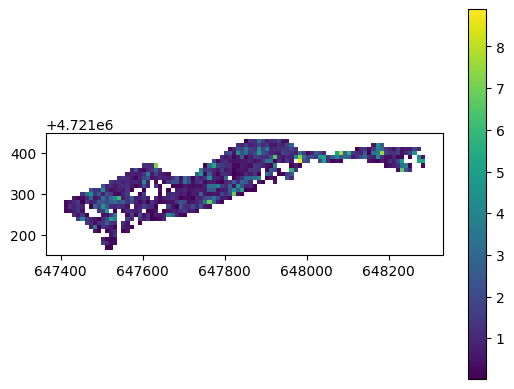

In [19]:
gdf.plot(column='agb', legend=True)

In [12]:
gdf.drop(columns=['hag']).to_file(f'BIOMASA/SHP/{vuelo.upper()}_ZONA{z}')

IsADirectoryError: [Errno 21] Is a directory: 'BIOMASA/SHP/LIDA2_ZONA1'

# Mapas de Biomasa

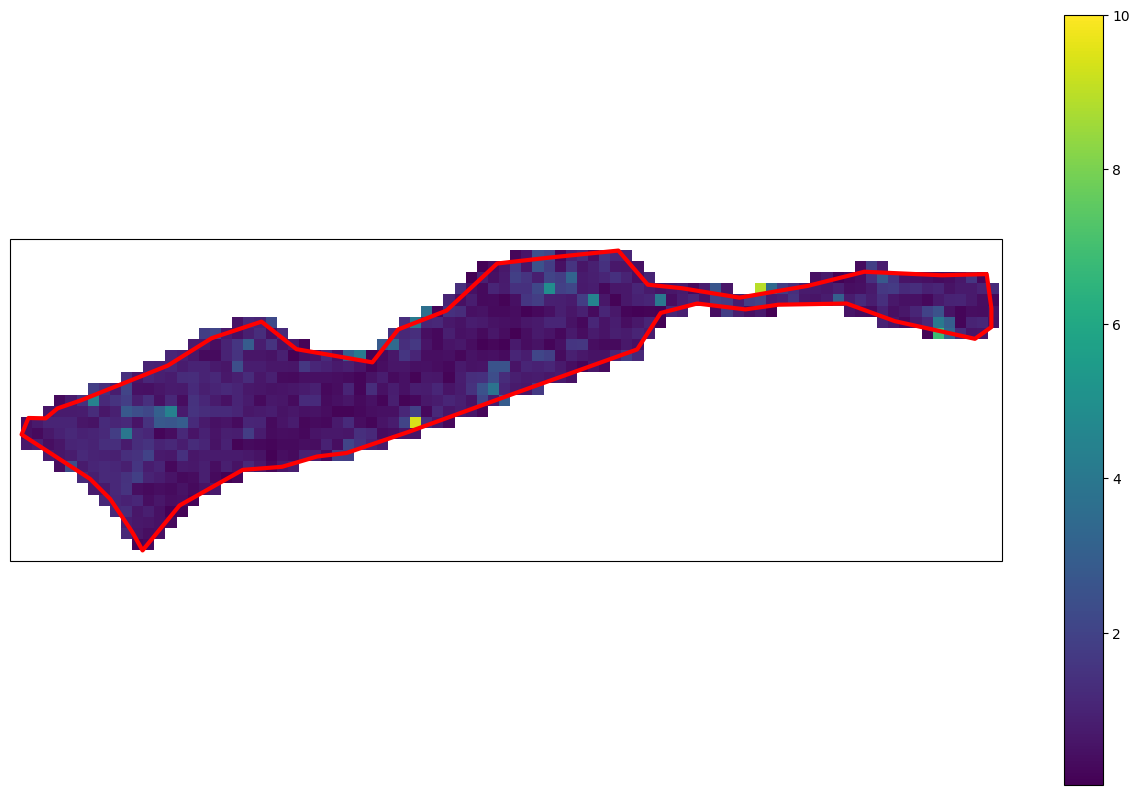

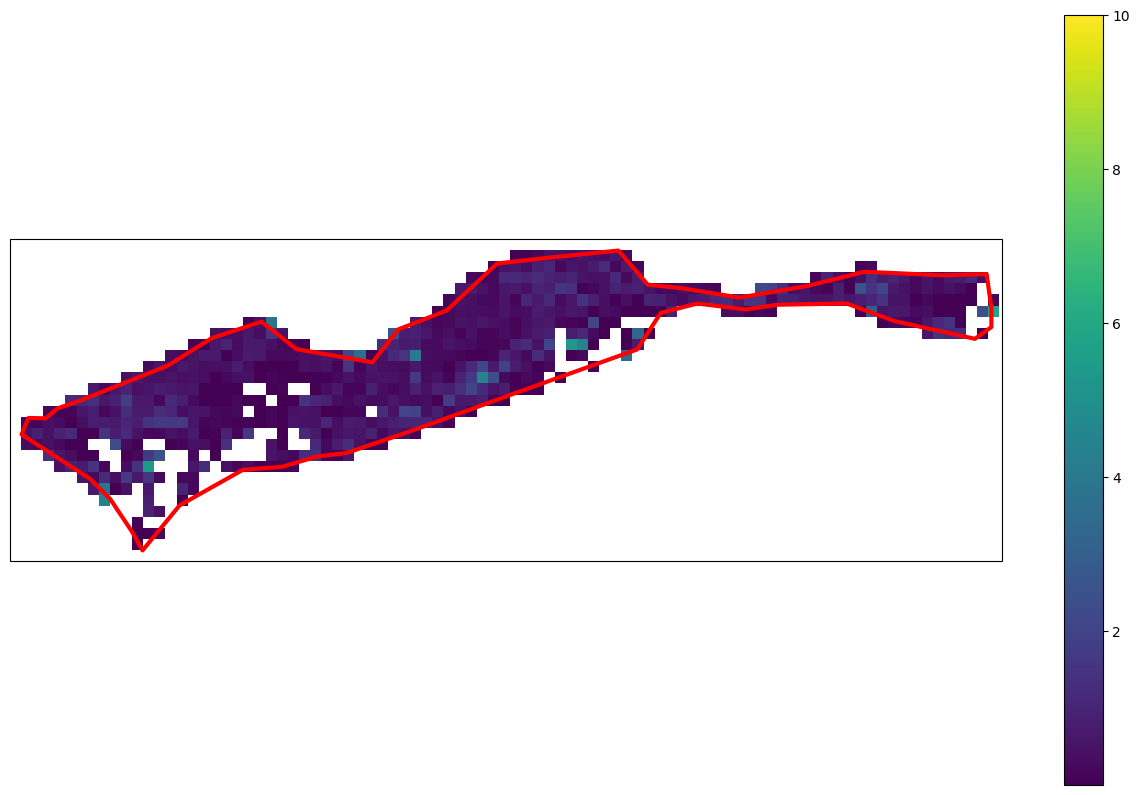

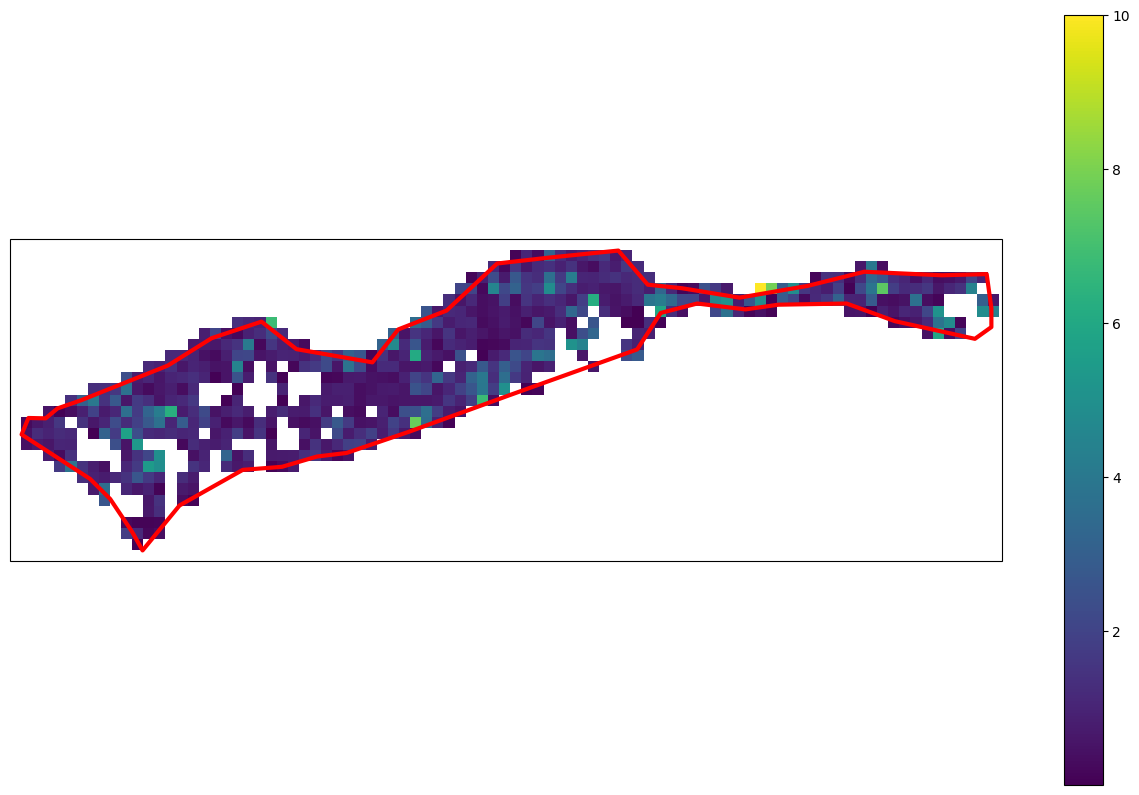

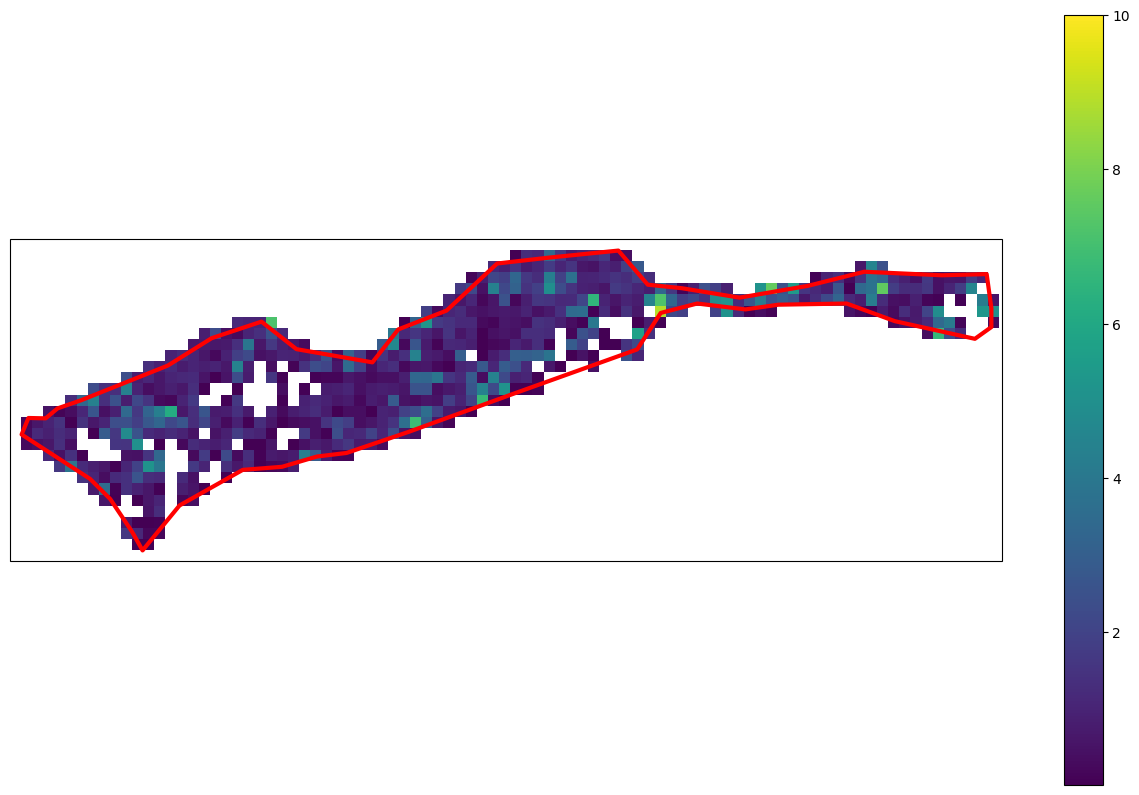

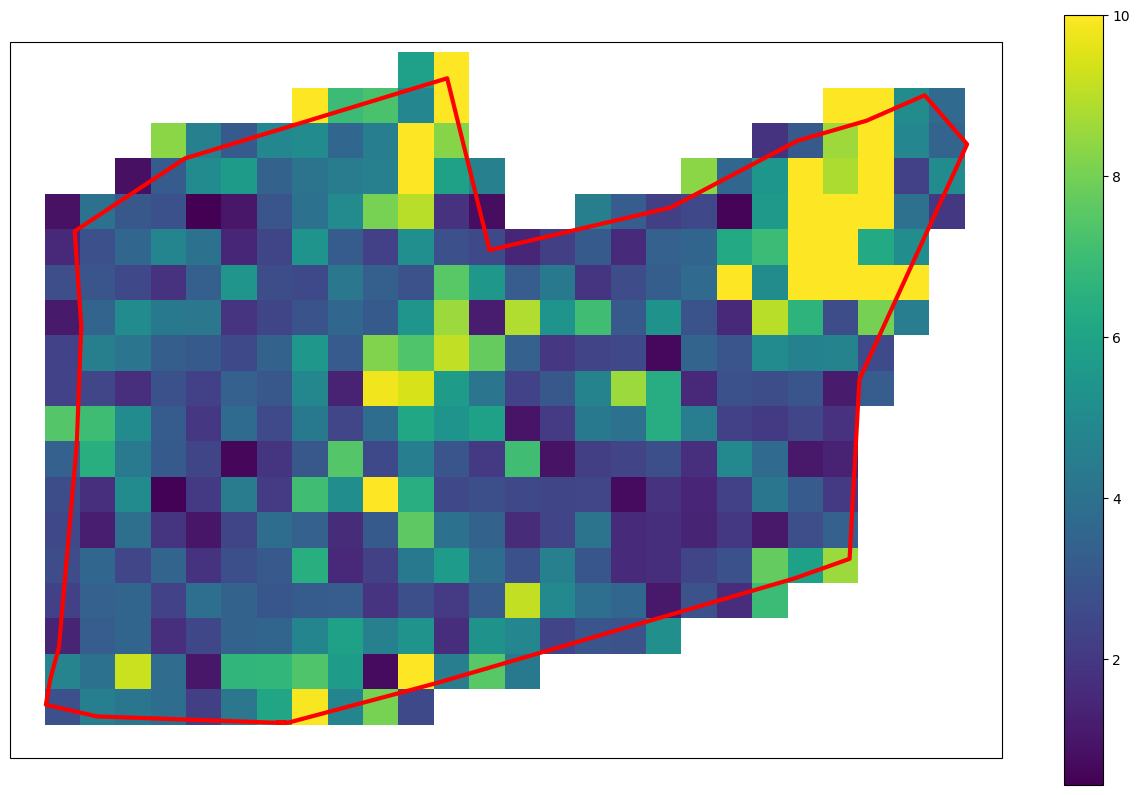

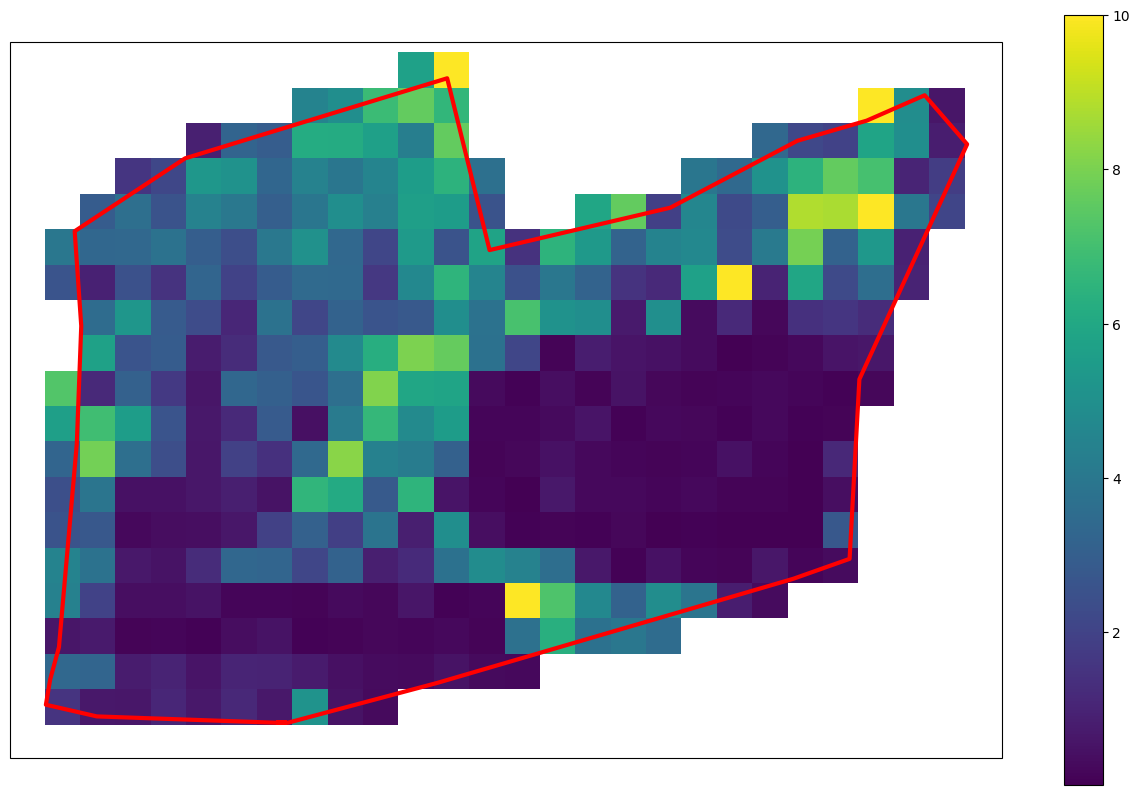

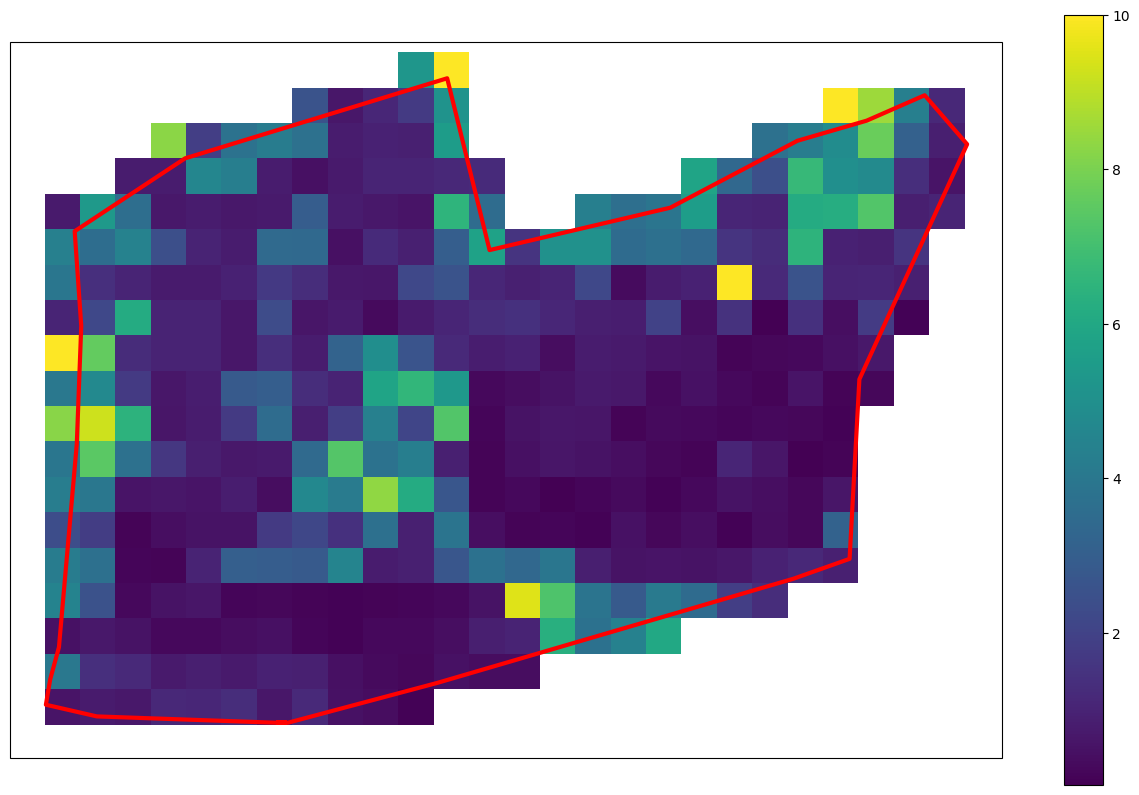

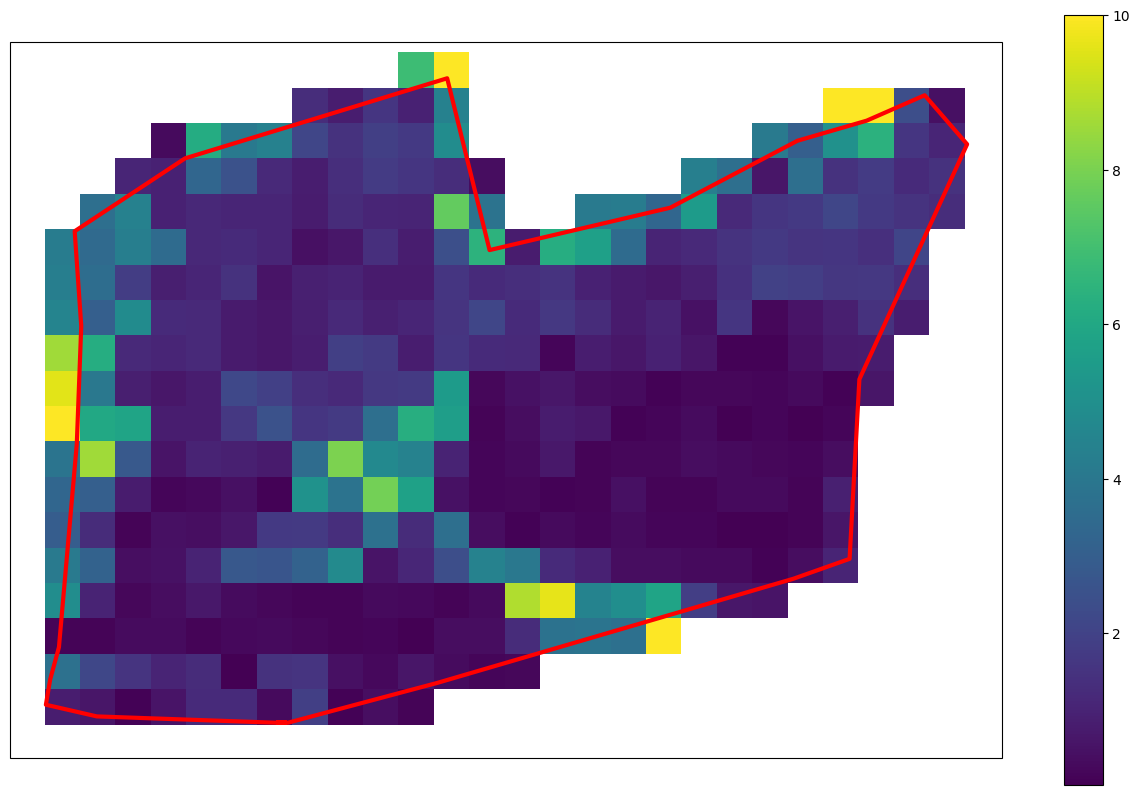

In [27]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


for z in [1, 2]:
    for vuelo in ['lida2', 'lida3', 'vuelo1', 'vuelo2']:
        zonas = gpd.read_file('shp/zonas_estudio.shp')
        zona = zonas[zonas.Id == z]
            
        gdf = gpd.read_file(f'BIOMASA/SHP/{vuelo.upper()}_ZONA{z}')
        
        proj = ccrs.epsg(25830)
        
        fig = plt.figure(figsize=(16, 10))
        ax = plt.axes(projection=proj)
        
        buffer = 10
        
        minx, miny, maxx, maxy = zona.iloc[0].geometry.bounds
            
        ax.set_extent([minx - buffer, maxx + buffer, miny - buffer, maxy + buffer], crs=proj)
        gdf[gdf['agb'] < 60].plot(ax=ax, cmap='viridis', column='agb', legend=True, vmax = 10)
        zona.plot(ax=ax, facecolor=(1,1,1,0), edgecolor='red', linewidth=3)
        plt.savefig(f'BIOMASA/IMAGENES/biomasa_{''.join(vuelo.split('_'))}_zona{z}.png', bbox_inches = 'tight')

In [37]:
gdf

,hag,length,min,max,p10,p75,mean,kurtosis,agb,geometry
0,[3.06898193 3.36898193 2.31898193 ... 3.517006...,5734.0,0.208999,4.774011,1.844995,3.594990,3.006074,0.734789,2.763591,"POLYGON ((646671 4721878, 646661 4721878, 6466..."
1,[4.6019873 3.64700195 2.88500732 ... 4.803010...,8732.0,0.202002,6.219980,2.443000,4.375977,3.717478,1.170595,4.742961,"POLYGON ((646671 4721888, 646661 4721888, 6466..."
2,[4.06301025 3.77301025 4.21301025 ... 0.863017...,5908.0,0.200007,5.403010,1.198979,3.447981,2.730621,-0.165395,1.403055,"POLYGON ((646671 4721898, 646661 4721898, 6466..."
3,[0.96 3.25 4.13397949 ... 2.752978...,5290.0,0.200000,5.895994,1.913972,4.146021,3.332842,0.259290,2.256441,"POLYGON ((646671 4721908, 646661 4721908, 6466..."
4,[1.75401855 1.34297852 3.18401855 ... 2.213020...,1948.0,0.202979,6.104019,0.603003,3.432986,2.535305,-0.704433,2.630016,"POLYGON ((646671 4721918, 646661 4721918, 6466..."
...,...,...,...,...,...,...,...,...,...,...
489,[4.97501465 2.57198975 5.52501465 ... 3.308981...,2498.0,0.269016,6.827000,1.906584,5.253972,4.230853,0.061074,1.980128,"POLYGON ((646921 4722018, 646911 4722018, 6469..."
490,[3.54799316 2.30500488 1.73702637 ... 3.384021...,8934.0,0.202029,7.073997,1.304614,5.185753,3.922368,-0.634752,5.019411,"POLYGON ((646921 4722028, 646911 4722028, 6469..."
491,[5.03701172 5.53797607 4.30799316 ... 3.458981...,11514.0,0.204006,6.367012,0.821292,3.871973,2.810834,-0.958154,3.493956,"POLYGON ((646921 4722038, 646911 4722038, 6469..."
492,[5.46101563 2.86101563 4.59298096 ... 0.334006...,2148.0,0.202000,6.022971,0.670996,3.899001,2.887801,-0.927006,3.708500,"POLYGON ((646921 4722048, 646911 4722048, 6469..."
